In [1]:
!pip install timm
!pip install mlflow
!pip install einops

In [17]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import os
import timm
import random
import matplotlib.ticker as ticker
import torch.nn.functional as F
import json
import torchvision

from tqdm import tqdm, trange
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from pathlib import Path
from PIL import Image
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights


In [24]:
train_dir = Path("/Users/jeesuppark/Downloads/aihub-meat-image 2/Training")

########## IMAGE ########

image_dirs = [
    train_dir / "[image]cow_seg_1",
    train_dir / "[image]cow_seg_2",
    train_dir / "[image]cow_seg_3"
]

filepaths = []

for image_dir in image_dirs:
    grade = int(image_dir.stem[-1])  # Extract the last character of the directory name as the grade
    filepaths.extend([str(image_dir / file) for file in os.listdir(image_dir) if file.endswith('.jpg')])

data = pd.DataFrame(filepaths, columns=['Filepath','Grade'])

data['Grade'] = [Path(filepath).stem.split('_')[-2] for filepath in data['Filepath']]
data['Grade'] = data['Grade'].apply(gradify)-1

train_data = data
print(train_data)


ValueError: Shape of passed values is (3000, 1), indices imply (3000, 2)

In [4]:
train_data = pd.merge(data, grade_data, on='File ID', how='inner')
train_data.drop('File ID', axis = 1,inplace=True)
print(train_data)

                                               Filepath Grade
0     /Users/jeesuppark/Downloads/aihub-meat-image 2...     0
1     /Users/jeesuppark/Downloads/aihub-meat-image 2...     0
2     /Users/jeesuppark/Downloads/aihub-meat-image 2...     0
3     /Users/jeesuppark/Downloads/aihub-meat-image 2...     0
4     /Users/jeesuppark/Downloads/aihub-meat-image 2...     0
...                                                 ...   ...
2995  /Users/jeesuppark/Downloads/aihub-meat-image 2...     2
2996  /Users/jeesuppark/Downloads/aihub-meat-image 2...     2
2997  /Users/jeesuppark/Downloads/aihub-meat-image 2...     2
2998  /Users/jeesuppark/Downloads/aihub-meat-image 2...     2
2999  /Users/jeesuppark/Downloads/aihub-meat-image 2...     2

[3000 rows x 2 columns]


In [5]:
valid_dir = Path("/Users/jeesuppark/Downloads/aihub-meat-image 2/Validation")

########## IMAGE ########
image_dirs = [
    valid_dir / "[image]cow_seg_1",
    valid_dir / "[image]cow_seg_2",
    valid_dir / "[image]cow_seg_3"
]

filepaths = []

for image_dir in image_dirs:
    grade = int(image_dir.stem[-1])  # Extract the last character of the directory name as the grade
    filepaths.extend([str(image_dir / file) for file in os.listdir(image_dir) if file.endswith('.jpg')])

valid_data = pd.DataFrame(filepaths, columns=['Filepath'])

valid_data['File ID'] = [Path(filepath).stem.split('_')[-1] for filepath in valid_data['Filepath']]
print(valid_data)


######## LABEL #############
label_dirs = [
    valid_dir / "[label]cow_seg_1",
    valid_dir / "[label]cow_seg_2",
    valid_dir / "[label]cow_seg_3"
]

valid_label = pd.DataFrame(columns=['File ID', 'Grade'])

for label_dir in label_dirs:
    # Get all JSON file paths in the label_dir
    json_files = label_dir.glob("*.json")

    for json_file in json_files:
        # Load the JSON file
        with open(json_file, 'r') as f:
            label_json = json.load(f)

        # Extract the points from the label JSON
        points = label_json['label_info']['shapes'][0]['points']
        grade = int(label_json['label_info']['shapes'][0]['grade'])-1


        # Extract the last ID from the file name
        file_id = json_file.stem.split('_')[-1]

        # Create a temporary DataFrame with the current data
        temp_df = pd.DataFrame({
            'File ID': [file_id],
            'Grade': [grade]
        })

        # Concatenate the temporary DataFrame with the main points_data DataFrame
        valid_label = pd.concat([valid_label, temp_df], ignore_index=True)

print(valid_label)


                                               Filepath File ID
0     /Users/jeesuppark/Downloads/aihub-meat-image 2...  069878
1     /Users/jeesuppark/Downloads/aihub-meat-image 2...  070440
2     /Users/jeesuppark/Downloads/aihub-meat-image 2...  069887
3     /Users/jeesuppark/Downloads/aihub-meat-image 2...  070871
4     /Users/jeesuppark/Downloads/aihub-meat-image 2...  071206
...                                                 ...     ...
1495  /Users/jeesuppark/Downloads/aihub-meat-image 2...  076499
1496  /Users/jeesuppark/Downloads/aihub-meat-image 2...  072172
1497  /Users/jeesuppark/Downloads/aihub-meat-image 2...  070765
1498  /Users/jeesuppark/Downloads/aihub-meat-image 2...  069552
1499  /Users/jeesuppark/Downloads/aihub-meat-image 2...  077036

[1500 rows x 2 columns]
     File ID Grade
0     069946     0
1     070634     0
2     070458     0
3     070663     0
4     070399     0
...      ...   ...
1495  074158     2
1496  072825     2
1497  075460     2
1498  074230     

In [6]:
test_data = pd.merge(valid_data, valid_label, on='File ID', how='inner')
test_data.drop('File ID', axis = 1,inplace=True)

print(test_data)

                                               Filepath Grade
0     /Users/jeesuppark/Downloads/aihub-meat-image 2...     0
1     /Users/jeesuppark/Downloads/aihub-meat-image 2...     0
2     /Users/jeesuppark/Downloads/aihub-meat-image 2...     0
3     /Users/jeesuppark/Downloads/aihub-meat-image 2...     0
4     /Users/jeesuppark/Downloads/aihub-meat-image 2...     0
...                                                 ...   ...
1495  /Users/jeesuppark/Downloads/aihub-meat-image 2...     2
1496  /Users/jeesuppark/Downloads/aihub-meat-image 2...     2
1497  /Users/jeesuppark/Downloads/aihub-meat-image 2...     2
1498  /Users/jeesuppark/Downloads/aihub-meat-image 2...     2
1499  /Users/jeesuppark/Downloads/aihub-meat-image 2...     2

[1500 rows x 2 columns]


In [7]:
class CreateImageDataset(Dataset):
    def __init__(self, data, transform=None):
        super().__init__()
        self.data = data
        self.transform = transform


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data['Filepath'].iloc[idx]
        label = self.data['Grade'].iloc[idx]

        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)
        return image, label

transformation = transforms.Compose([
    transforms.Resize([224,224]),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    # # transforms.RandomGrayscale(),
    # transforms.RandomAffine(translate=(0.05,0.05), degrees=0),
    transforms.ToTensor(),
    ])
valid_transformation = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    ])


In [8]:
#Define hyperparameters
batch_size = 32
lr = 1e-5
epochs = 3

In [9]:
train_data.reset_index(drop=True, inplace=True)  # Reset the index of the train_data DataFrame
test_data.reset_index(drop=True, inplace=True)  # Reset the index of the test_data DataFrame
train_dataset = CreateImageDataset(train_data, transform=transformation)
valid_dataset = CreateImageDataset(test_data, transform=valid_transformation)

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [11]:
import mlflow

cpu
Epoch 1/3


100%|███████████████████████████████████████████| 94/94 [10:53<00:00,  6.95s/it]


The Validation Loss is 0.953257938648792 and the validation accuracy is 0.6177811550151976
The Training Loss is 1.0366220987857657 and the training accuracy is 0.49490248226950356
Epoch 2/3


100%|███████████████████████████████████████████| 94/94 [11:18<00:00,  7.22s/it]


The Validation Loss is 0.8060146709705921 and the validation accuracy is 0.6316489361702128
The Training Loss is 0.8701919887928252 and the training accuracy is 0.6283244680851063
Epoch 3/3


100%|███████████████████████████████████████████| 94/94 [11:24<00:00,  7.28s/it]


The Validation Loss is 0.7291135293372134 and the validation accuracy is 0.6612841945288753
The Training Loss is 0.7336635285235465 and the training accuracy is 0.662677304964539


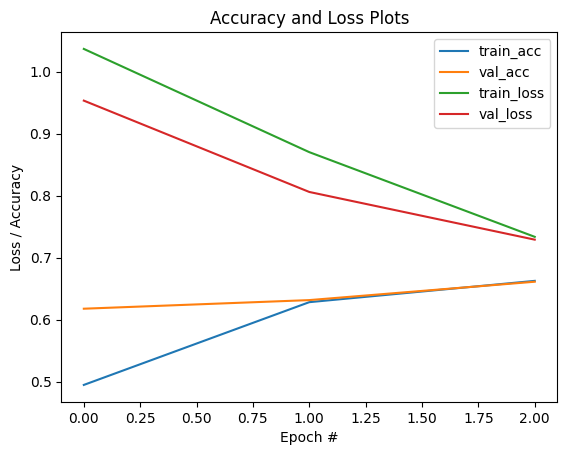

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

# checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/ViT-aihub/model_checkpoint.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


scheduler = ReduceLROnPlateau(optimizer, patience = 2, factor = 0.5, threshold = 0.005)
train_loss, val_loss, train_acc, val_acc =[], [], [], []
best_acc = 0
with mlflow.start_run() as run:
    mlflow.log_param("lr", lr)
    mlflow.log_param("epoch", epochs)
    mlflow.log_param("batch size", batch_size)
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        #training
        model.train()
        total_loss, total_correct = 0,0
        for x, y in tqdm(train_dataloader):
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            _, preds = torch.max(output, 1)
            loss = criterion(output, y.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_correct += torch.sum(preds == y).item()/len(x)
        train_loss.append(total_loss/len(train_dataloader))
        train_acc.append(total_correct/len(train_dataloader))

        #validation
        model.eval()
        total_loss, total_correct = 0,0
        with torch.no_grad():
            for x, y in valid_dataloader:
                x = x.to(device)
                y = y.to(device)
                output = model(x)
                _, preds = torch.max(output, 1)
                loss = criterion(output, y.long())
                optimizer.zero_grad()
                total_loss += loss.item()
                total_correct += torch.sum(preds == y).item()/len(x)
            val_loss.append(total_loss/len(valid_dataloader))
            val_acc.append(total_correct/len(valid_dataloader))
        scheduler.step(val_loss[-1])
        # Logging metrics with MLflow
        mlflow.log_metric("train_loss", train_loss[-1])
        mlflow.log_metric("train_acc", train_acc[-1])
        mlflow.log_metric("val_loss", val_loss[-1])
        mlflow.log_metric("val_acc", val_acc[-1])

        # saving best model
        if val_acc[-1]>best_acc:
            best_acc = val_acc[-1]
            torch.save({
                'epoch':epoch,
                'model_state_dict':model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss':val_loss[-1],
                'acc':val_acc[-1]
            }, 'model_checkpoint.pt')
        print('The Validation Loss is {} and the validation accuracy is {}'.format(val_loss[-1],val_acc[-1]))
        print('The Training Loss is {} and the training accuracy is {}'.format(train_loss[-1],train_acc[-1]))

# Plot the curves
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.title('Accuracy and Loss Plots')
plt.savefig("plot.png")  # Save the plot as an image
plt.show()